In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from joblib import dump, load

import xgboost as xgb

### Utility functions

In [2]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [3]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [False,True] # classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Data Preprocessing

In [4]:
data = pd.read_csv('nasa.csv')
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [5]:
data.columns

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')

In [6]:
data.shape

(4687, 40)

In [7]:
data = data.drop(['Neo Reference ID', 'Name', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 
                  'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date', 
                  'Epoch Date Close Approach', 'Relative Velocity km per hr', 'Miles per hour','Miss Dist.(lunar)',
                  'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body', 'Orbit ID', 
                  'Orbit Determination Date', 'Epoch Osculation', 'Equinox'], axis=1)

In [8]:
features = data.iloc[:,:-1]
X = features.values
y = [1 if item is True else 0 for item in data['Hazardous']]

In [9]:
X.shape

(4687, 19)

In [10]:
len(y)

4687

In [11]:
features.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,21.6,0.127220,0.284472,6.115834,0.419483,5,0.025282,4.634,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551
1,21.3,0.146068,0.326618,18.113985,0.383014,3,0.186935,5.457,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330
2,20.3,0.231502,0.517654,7.590711,0.050956,0,0.043058,4.557,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371
3,27.4,0.008801,0.019681,11.173874,0.285322,6,0.005512,5.093,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277
4,21.6,0.127220,0.284472,9.840831,0.407832,1,0.034798,5.154,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [13]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [14]:
X_train.shape

(3515, 19)

In [15]:
# param = {
#     'eta': 0.1, 
#     'max_depth': 10,  
#     'lambda': 0.7
#     'objective': 'multi:softprob',  
#     'num_class': 2}

# steps = 100

## Model Design

In [15]:
xgb_model = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

In [16]:
grid = GridSearchCV(xgb_model,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3,
                    verbose=1)

xgboost_model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

In [17]:
params = xgboost_model.best_params_

In [18]:
params

{'colsample_bytree': 0.7,
 'eta': 0.05,
 'gamma': 0.0,
 'max_depth': 5,
 'min_child_weight': 1}

## Save model

In [19]:
dump(xgboost_model, 'xgb_opt.joblib') 

['xgb_opt.joblib']

In [ ]:
# Load the pre-trained model
# xgb_model = load('xgb_opt.joblib') 

## Visualise the results

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

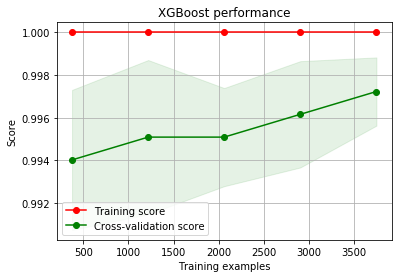

In [23]:
cv = StratifiedKFold(n_splits=5)
model = xgb.XGBClassifier(colsample_bytree = 0.7, eta = 0.05, gamma = 0.0, max_depth = 5, min_child_weight = 1)
plot_learning_curve(model, 'XGBoost performance', X, y, cv=cv)

In [24]:
xgboost_model = model.fit(X_train,y_train)

## Classification Report

In [25]:
preds = xgboost_model.predict(X_test)

Confusion matrix, without normalization
[[991   0]
 [  5 176]]


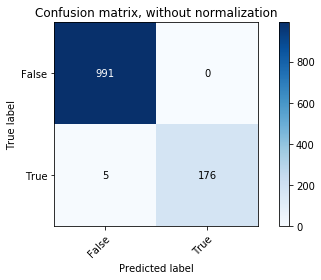

In [26]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[1.         0.        ]
 [0.02762431 0.97237569]]


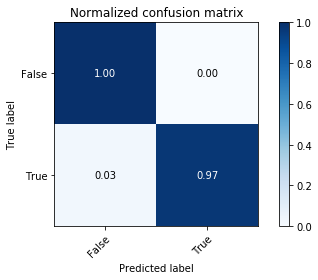

In [27]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, preds, normalize=True,
                      title='Normalized confusion matrix')

In [28]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       991
           1       1.00      0.97      0.99       181

   micro avg       1.00      1.00      1.00      1172
   macro avg       1.00      0.99      0.99      1172
weighted avg       1.00      1.00      1.00      1172

